# Competition for glucose, complex model, and social objective (model), linear/exponential growth rate

In [1]:
import cobra
import pandas as pd
import numpy as np
import pickle
from cobra.flux_analysis import pfba

In [2]:
M = cobra.io.load_json_model('Recon2.2Twocelltypestogether.json')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
model = M.copy()

In [4]:
model.solver='glpk'
sol = model.optimize()
sol.objective_value

0.33777507557717323

In [5]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_M0_e.lower_bound=-0.1

In [6]:
model.solver='glpk'
sol = model.optimize()
sol.objective_value

0.04999999999999995

## Growing with time (Stepwise growth)

### µ1=0.2; µ2=0.3

In [14]:
model2=model.copy()

0.015384615384615353 0.03461538461538462


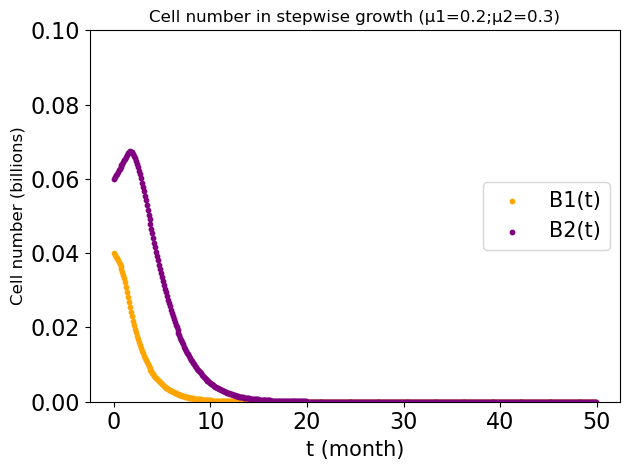

In [15]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[]
Fluxes1_list=[]
Fluxes2_list=[]

b1_list=[]
b2_list=[]

RequiredXproduction_list=[]
RequiredYproduction_list=[]

Bias_list=[]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = []
B2_vals = []

def B1(t):
    if t <= 0:
        return 0.04
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.06
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(0,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    
    A=0.05
    b1=A*0.2*B1_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b2=A*0.3*B2_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)

    model2.reactions.biomass_reaction_Cell1_New.upper_bound=b1
    model2.reactions.biomass_reaction_Cell2_New.upper_bound=b2
    model2.reactions.DI1X.upper_bound=0.65*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=0.65*B2_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass_reaction_Cell1_New']
    Fluxes2=sol.fluxes.loc['biomass_reaction_Cell2_New']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes4/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)

    T=t/10
    T_list.append(T)

print(Fluxes1_list[0],Fluxes2_list[0])#,RequiredXproduction_list[0],RequiredYproduction_list[0],
    # b1_list[0],b2_list[0],Bias_list[0])
    
    
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
# plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right')

plt.xlabel("t (month)",fontsize=15)

plt.ylim(0,0.1)
plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='center right')

# plt.ylim(0,3)
# plt.title('Stepwise growth (µ1=0.2;µ2=0.3)',fontsize=14)
# plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
# plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)

# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("Actual growth bias value (m C-Molar)",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2)',dpi=600)

In [21]:
print(B1_vals[-1],B2_vals[-1])

0.005714397483881719 0.06285500009084015


# With regulation

## With stepwise regulation

### µ1=0.2; µ2=0.3

In [11]:
model11=model.copy()

In [12]:
model1=model11.copy()
model2=model11.copy()
model3=model11.copy()

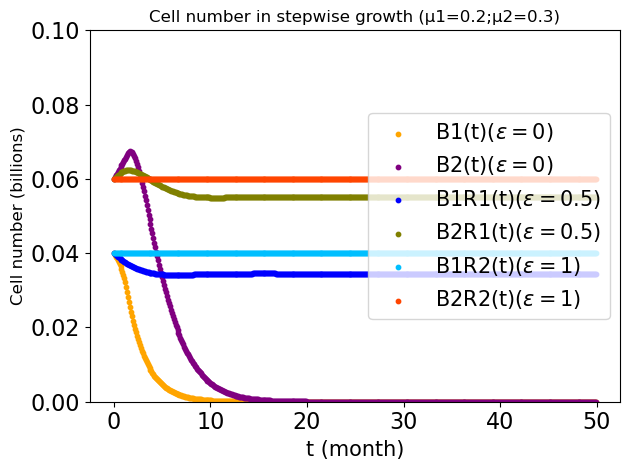

In [13]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = []
B2RS1_vals = []

B1RS2_vals=[]
B2RS2_vals=[]
B1RS3_vals=[]
B2RS3_vals=[]

FluxesS1_list=[]
FluxesS2_list=[]
Fluxes1SR1_list=[]
Fluxes2SR1_list=[]
Fluxes1SR2_list=[]
Fluxes2SR2_list=[]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.04
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.06
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.04
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.06
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.04
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.06
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(0,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)

    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    

    
    A=0.05
    B=0.5
    D=1
    b1RS1=A*0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=A*0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=A*0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],B)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],B)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],B))
    b2RS2=A*0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],B)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],B)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],B))
    b1RS3=A*0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],D)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],D)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],D))
    b2RS3=A*0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],D)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],D)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],D))
    
#     B1RS1_vals.append(B1RS1_t)
#     B2RS1_vals.append(B2RS1_t)
#     B1RS2_vals.append(B1RS2_t)
#     B2RS2_vals.append(B2RS2_t)
#     B1RS3_vals.append(B1RS3_t)
#     B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass_reaction_Cell1_New.upper_bound=b1RS1
    model1.reactions.biomass_reaction_Cell2_New.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=0.65*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=0.65*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass_reaction_Cell1_New.upper_bound=b1RS2
    model2.reactions.biomass_reaction_Cell2_New.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=0.65*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=0.65*B2RS2_vals[-1]
    ### For regulation power=1
    model3.reactions.biomass_reaction_Cell1_New.upper_bound=b1RS3
    model3.reactions.biomass_reaction_Cell2_New.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=0.65*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=0.65*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass_reaction_Cell1_New']
    FluxesS2=sol1.fluxes.loc['biomass_reaction_Cell2_New']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass_reaction_Cell1_New']
    Fluxes2SR1=sol2.fluxes.loc['biomass_reaction_Cell2_New']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass_reaction_Cell1_New']
    Fluxes2SR2=sol3.fluxes.loc['biomass_reaction_Cell2_New']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
# print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,0.1)
plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\varepsilon=0$'')','B2(t)''('r'$\varepsilon=0$'')','B1R1(t)''('r'$\varepsilon=0.5$'')',
            'B2R1(t)''('r'$\varepsilon=0.5$'')','B1R2(t)''('r'$\varepsilon=1$'')','B2R2(t)''('r'$\varepsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\varepsilon=0$'')','b2(t)''('r'$\varepsilon=0$'')','b1R1(t)''('r'$\varepsilon=0.5$'')',
#             'b2R1(t)''('r'$\varepsilon=0.5$'')','b1R2(t)''('r'$\varepsilon=1$'')','b2R2(t)''('r'$\varepsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for stepwise growth with regulation',dpi=600)